<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[21:05:04] /work/mxnet/src/storage/storage.cc:199: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


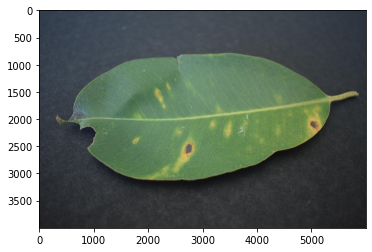

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

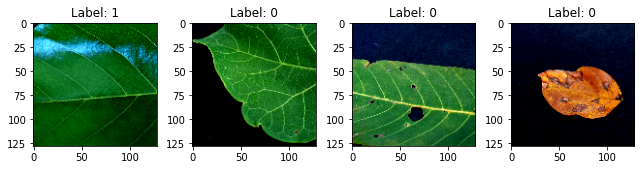

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[21:05:10] /work/mxnet/src/storage/storage.cc:199: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[21:05:12] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:97: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2547341541464103 samples/sec                   batch loss = 1.9584826231002808 | accuracy = 0.4


Epoch[1] Batch[10] Speed: 1.258076477797152 samples/sec                   batch loss = 0.85915207862854 | accuracy = 0.525


Epoch[1] Batch[15] Speed: 1.258736163233703 samples/sec                   batch loss = 3.2158939838409424 | accuracy = 0.55


Epoch[1] Batch[20] Speed: 1.2661078013861125 samples/sec                   batch loss = 0.7022656202316284 | accuracy = 0.5625


Epoch[1] Batch[25] Speed: 1.2634282043216565 samples/sec                   batch loss = 0.4672186076641083 | accuracy = 0.54


Epoch[1] Batch[30] Speed: 1.2617218216330202 samples/sec                   batch loss = 0.4164731502532959 | accuracy = 0.55


Epoch[1] Batch[35] Speed: 1.2649801938937764 samples/sec                   batch loss = 1.283265471458435 | accuracy = 0.5428571428571428


Epoch[1] Batch[40] Speed: 1.26134371485714 samples/sec                   batch loss = 0.9597876667976379 | accuracy = 0.53125


Epoch[1] Batch[45] Speed: 1.2671198895081452 samples/sec                   batch loss = 0.6952225565910339 | accuracy = 0.5555555555555556


Epoch[1] Batch[50] Speed: 1.268114043080553 samples/sec                   batch loss = 0.5005800127983093 | accuracy = 0.575


Epoch[1] Batch[55] Speed: 1.2641540938564877 samples/sec                   batch loss = 2.085009813308716 | accuracy = 0.5909090909090909


Epoch[1] Batch[60] Speed: 1.2650354200833192 samples/sec                   batch loss = 1.997806429862976 | accuracy = 0.5833333333333334


Epoch[1] Batch[65] Speed: 1.2665217549506345 samples/sec                   batch loss = 1.1683293581008911 | accuracy = 0.5846153846153846


Epoch[1] Batch[70] Speed: 1.2638265073368338 samples/sec                   batch loss = 0.357181578874588 | accuracy = 0.5964285714285714


Epoch[1] Batch[75] Speed: 1.2611461195280818 samples/sec                   batch loss = 0.32875823974609375 | accuracy = 0.5866666666666667


Epoch[1] Batch[80] Speed: 1.260934275858985 samples/sec                   batch loss = 0.7372934222221375 | accuracy = 0.59375


Epoch[1] Batch[85] Speed: 1.2663313275483032 samples/sec                   batch loss = 1.0382294654846191 | accuracy = 0.6


Epoch[1] Batch[90] Speed: 1.2588954068505178 samples/sec                   batch loss = 0.9174875617027283 | accuracy = 0.6


Epoch[1] Batch[95] Speed: 1.2634558918217946 samples/sec                   batch loss = 0.5461381673812866 | accuracy = 0.6


Epoch[1] Batch[100] Speed: 1.2654420866876632 samples/sec                   batch loss = 0.3768044710159302 | accuracy = 0.61


Epoch[1] Batch[105] Speed: 1.2658500654344838 samples/sec                   batch loss = 0.9003496766090393 | accuracy = 0.611904761904762


Epoch[1] Batch[110] Speed: 1.2676632243672306 samples/sec                   batch loss = 0.32732102274894714 | accuracy = 0.6068181818181818


Epoch[1] Batch[115] Speed: 1.2659631582827462 samples/sec                   batch loss = 0.5411380529403687 | accuracy = 0.6021739130434782


Epoch[1] Batch[120] Speed: 1.2579010305478497 samples/sec                   batch loss = 0.4166727066040039 | accuracy = 0.6020833333333333


Epoch[1] Batch[125] Speed: 1.2665109510607053 samples/sec                   batch loss = 0.7225331664085388 | accuracy = 0.606


Epoch[1] Batch[130] Speed: 1.2677999212745452 samples/sec                   batch loss = 0.5768186450004578 | accuracy = 0.6076923076923076


Epoch[1] Batch[135] Speed: 1.261022132581425 samples/sec                   batch loss = 1.027085542678833 | accuracy = 0.6092592592592593


Epoch[1] Batch[140] Speed: 1.265851784600176 samples/sec                   batch loss = 0.4618231952190399 | accuracy = 0.6160714285714286


Epoch[1] Batch[145] Speed: 1.2759866466145833 samples/sec                   batch loss = 0.27716463804244995 | accuracy = 0.6224137931034482


Epoch[1] Batch[150] Speed: 1.2762478476859604 samples/sec                   batch loss = 0.7134377360343933 | accuracy = 0.6216666666666667


Epoch[1] Batch[155] Speed: 1.2760558433242344 samples/sec                   batch loss = 0.4320525825023651 | accuracy = 0.6258064516129033


Epoch[1] Batch[160] Speed: 1.269788467938235 samples/sec                   batch loss = 0.6636561751365662 | accuracy = 0.6296875


Epoch[1] Batch[165] Speed: 1.274487417969745 samples/sec                   batch loss = 0.5100446343421936 | accuracy = 0.6272727272727273


Epoch[1] Batch[170] Speed: 1.2719747546171134 samples/sec                   batch loss = 0.7161973714828491 | accuracy = 0.6294117647058823


Epoch[1] Batch[175] Speed: 1.2622385987699332 samples/sec                   batch loss = 0.4304552972316742 | accuracy = 0.6328571428571429


Epoch[1] Batch[180] Speed: 1.2689853519813865 samples/sec                   batch loss = 0.5380933284759521 | accuracy = 0.6375


Epoch[1] Batch[185] Speed: 1.2622576869991842 samples/sec                   batch loss = 0.6870954632759094 | accuracy = 0.6432432432432432


Epoch[1] Batch[190] Speed: 1.2633893867771966 samples/sec                   batch loss = 1.3947559595108032 | accuracy = 0.6407894736842106


Epoch[1] Batch[195] Speed: 1.266904407980708 samples/sec                   batch loss = 0.6743754148483276 | accuracy = 0.6435897435897436


Epoch[1] Batch[200] Speed: 1.2634494217818377 samples/sec                   batch loss = 0.6905431747436523 | accuracy = 0.64375


Epoch[1] Batch[205] Speed: 1.2685361196964897 samples/sec                   batch loss = 0.5404720902442932 | accuracy = 0.6475609756097561


Epoch[1] Batch[210] Speed: 1.2686360708282567 samples/sec                   batch loss = 1.0442311763763428 | accuracy = 0.6464285714285715


Epoch[1] Batch[215] Speed: 1.2674958180051443 samples/sec                   batch loss = 0.29668891429901123 | accuracy = 0.6534883720930232


Epoch[1] Batch[220] Speed: 1.2639579976878839 samples/sec                   batch loss = 0.3000839948654175 | accuracy = 0.6590909090909091


Epoch[1] Batch[225] Speed: 1.2678429385223868 samples/sec                   batch loss = 0.3623831570148468 | accuracy = 0.66


Epoch[1] Batch[230] Speed: 1.2667921034194036 samples/sec                   batch loss = 0.5920801758766174 | accuracy = 0.6630434782608695


Epoch[1] Batch[235] Speed: 1.265242823645958 samples/sec                   batch loss = 0.14665742218494415 | accuracy = 0.6648936170212766


Epoch[1] Batch[240] Speed: 1.264306993930847 samples/sec                   batch loss = 0.7546089291572571 | accuracy = 0.6614583333333334


Epoch[1] Batch[245] Speed: 1.2613235163325272 samples/sec                   batch loss = 0.5155869722366333 | accuracy = 0.6581632653061225


Epoch[1] Batch[250] Speed: 1.2662542933747458 samples/sec                   batch loss = 0.6763802170753479 | accuracy = 0.658


Epoch[1] Batch[255] Speed: 1.269928891861463 samples/sec                   batch loss = 0.4133250117301941 | accuracy = 0.6588235294117647


Epoch[1] Batch[260] Speed: 1.2691301105241735 samples/sec                   batch loss = 1.0234483480453491 | accuracy = 0.6567307692307692


Epoch[1] Batch[265] Speed: 1.2674127058735365 samples/sec                   batch loss = 0.689982533454895 | accuracy = 0.6547169811320754


Epoch[1] Batch[270] Speed: 1.2610481033635734 samples/sec                   batch loss = 0.47651246190071106 | accuracy = 0.6546296296296297


Epoch[1] Batch[275] Speed: 1.2646816363082656 samples/sec                   batch loss = 0.6823498010635376 | accuracy = 0.6545454545454545


Epoch[1] Batch[280] Speed: 1.2608559070004295 samples/sec                   batch loss = 0.4648776352405548 | accuracy = 0.6535714285714286


Epoch[1] Batch[285] Speed: 1.25708480713771 samples/sec                   batch loss = 0.7606798410415649 | accuracy = 0.6526315789473685


Epoch[1] Batch[290] Speed: 1.2595499942642676 samples/sec                   batch loss = 1.111008644104004 | accuracy = 0.6543103448275862


Epoch[1] Batch[295] Speed: 1.2624783356480103 samples/sec                   batch loss = 0.4976171851158142 | accuracy = 0.6533898305084745


Epoch[1] Batch[300] Speed: 1.256971788138286 samples/sec                   batch loss = 0.40299534797668457 | accuracy = 0.6533333333333333


Epoch[1] Batch[305] Speed: 1.265498880511425 samples/sec                   batch loss = 0.5201154351234436 | accuracy = 0.6549180327868852


Epoch[1] Batch[310] Speed: 1.2670234304559451 samples/sec                   batch loss = 0.33262452483177185 | accuracy = 0.6580645161290323


Epoch[1] Batch[315] Speed: 1.2556477789046554 samples/sec                   batch loss = 0.7438886165618896 | accuracy = 0.6595238095238095


Epoch[1] Batch[320] Speed: 1.2613356543354781 samples/sec                   batch loss = 0.1637100726366043 | accuracy = 0.66015625


Epoch[1] Batch[325] Speed: 1.265135392704221 samples/sec                   batch loss = 0.337226927280426 | accuracy = 0.6623076923076923


Epoch[1] Batch[330] Speed: 1.259798170571638 samples/sec                   batch loss = 0.8462034463882446 | accuracy = 0.6621212121212121


Epoch[1] Batch[335] Speed: 1.2625272630361204 samples/sec                   batch loss = 0.49560555815696716 | accuracy = 0.6626865671641791


Epoch[1] Batch[340] Speed: 1.2556329309127878 samples/sec                   batch loss = 0.345854252576828 | accuracy = 0.6647058823529411


Epoch[1] Batch[345] Speed: 1.2642695514278368 samples/sec                   batch loss = 0.8297776579856873 | accuracy = 0.6652173913043479


Epoch[1] Batch[350] Speed: 1.2633388704569106 samples/sec                   batch loss = 0.26511526107788086 | accuracy = 0.665


Epoch[1] Batch[355] Speed: 1.2699607102211332 samples/sec                   batch loss = 0.4102415144443512 | accuracy = 0.6647887323943662


Epoch[1] Batch[360] Speed: 1.267310362706551 samples/sec                   batch loss = 0.7655008435249329 | accuracy = 0.6652777777777777


Epoch[1] Batch[365] Speed: 1.2709122482638338 samples/sec                   batch loss = 0.2698049247264862 | accuracy = 0.6664383561643835


Epoch[1] Batch[370] Speed: 1.268744193095283 samples/sec                   batch loss = 0.39813172817230225 | accuracy = 0.6682432432432432


Epoch[1] Batch[375] Speed: 1.2704259593970215 samples/sec                   batch loss = 0.43116945028305054 | accuracy = 0.6673333333333333


Epoch[1] Batch[380] Speed: 1.267956100277659 samples/sec                   batch loss = 1.3880314826965332 | accuracy = 0.6664473684210527


Epoch[1] Batch[385] Speed: 1.2648352361657553 samples/sec                   batch loss = 0.7444671392440796 | accuracy = 0.6668831168831169


Epoch[1] Batch[390] Speed: 1.2697220633334692 samples/sec                   batch loss = 0.3794855773448944 | accuracy = 0.6666666666666666


Epoch[1] Batch[395] Speed: 1.2710012121212122 samples/sec                   batch loss = 0.45876553654670715 | accuracy = 0.6683544303797468


Epoch[1] Batch[400] Speed: 1.2609336124783095 samples/sec                   batch loss = 0.7855921387672424 | accuracy = 0.668125


Epoch[1] Batch[405] Speed: 1.2608052140767387 samples/sec                   batch loss = 0.714847981929779 | accuracy = 0.6685185185185185


Epoch[1] Batch[410] Speed: 1.2579116880437171 samples/sec                   batch loss = 0.3998022675514221 | accuracy = 0.6707317073170732


Epoch[1] Batch[415] Speed: 1.2615502890166457 samples/sec                   batch loss = 0.524385929107666 | accuracy = 0.6692771084337349


Epoch[1] Batch[420] Speed: 1.2635385809613389 samples/sec                   batch loss = 0.8682292103767395 | accuracy = 0.6660714285714285


Epoch[1] Batch[425] Speed: 1.2672639355694055 samples/sec                   batch loss = 0.37963753938674927 | accuracy = 0.6670588235294118


Epoch[1] Batch[430] Speed: 1.2654425639254478 samples/sec                   batch loss = 0.6918731331825256 | accuracy = 0.6662790697674419


Epoch[1] Batch[435] Speed: 1.266000701169879 samples/sec                   batch loss = 0.5527642369270325 | accuracy = 0.6649425287356322


Epoch[1] Batch[440] Speed: 1.264170096617309 samples/sec                   batch loss = 0.47356292605400085 | accuracy = 0.6642045454545454


Epoch[1] Batch[445] Speed: 1.2608058773223194 samples/sec                   batch loss = 0.48889100551605225 | accuracy = 0.6646067415730337


Epoch[1] Batch[450] Speed: 1.2691862757468941 samples/sec                   batch loss = 0.5223459601402283 | accuracy = 0.6666666666666666


Epoch[1] Batch[455] Speed: 1.259969132392836 samples/sec                   batch loss = 0.3503740727901459 | accuracy = 0.6664835164835164


Epoch[1] Batch[460] Speed: 1.2590280461640175 samples/sec                   batch loss = 0.1573871523141861 | accuracy = 0.6679347826086957


Epoch[1] Batch[465] Speed: 1.2667739299363812 samples/sec                   batch loss = 0.5455560684204102 | accuracy = 0.6672043010752688


Epoch[1] Batch[470] Speed: 1.2616326340312318 samples/sec                   batch loss = 0.9389052987098694 | accuracy = 0.6664893617021277


Epoch[1] Batch[475] Speed: 1.2702835019426146 samples/sec                   batch loss = 0.5106242895126343 | accuracy = 0.6689473684210526


Epoch[1] Batch[480] Speed: 1.2612337213335572 samples/sec                   batch loss = 0.5881018042564392 | accuracy = 0.6697916666666667


Epoch[1] Batch[485] Speed: 1.2655836511961487 samples/sec                   batch loss = 0.4787394106388092 | accuracy = 0.6701030927835051


Epoch[1] Batch[490] Speed: 1.2709655865706795 samples/sec                   batch loss = 0.339839905500412 | accuracy = 0.6709183673469388


Epoch[1] Batch[495] Speed: 1.2626576279095145 samples/sec                   batch loss = 0.10380027443170547 | accuracy = 0.6717171717171717


Epoch[1] Batch[500] Speed: 1.2594810632474764 samples/sec                   batch loss = 0.5426819324493408 | accuracy = 0.6715


Epoch[1] Batch[505] Speed: 1.2672961948896224 samples/sec                   batch loss = 1.3880679607391357 | accuracy = 0.6707920792079208


Epoch[1] Batch[510] Speed: 1.2653936966450565 samples/sec                   batch loss = 1.0856221914291382 | accuracy = 0.6715686274509803


Epoch[1] Batch[515] Speed: 1.2660810485192506 samples/sec                   batch loss = 0.7960333824157715 | accuracy = 0.6713592233009709


Epoch[1] Batch[520] Speed: 1.264098944588544 samples/sec                   batch loss = 0.4359201490879059 | accuracy = 0.6711538461538461


Epoch[1] Batch[525] Speed: 1.2697520454498326 samples/sec                   batch loss = 0.30935439467430115 | accuracy = 0.6738095238095239


Epoch[1] Batch[530] Speed: 1.2667570003713315 samples/sec                   batch loss = 0.19902193546295166 | accuracy = 0.6726415094339623


Epoch[1] Batch[535] Speed: 1.2603127100791491 samples/sec                   batch loss = 0.45390626788139343 | accuracy = 0.6742990654205607


Epoch[1] Batch[540] Speed: 1.2679948156254068 samples/sec                   batch loss = 0.3331698477268219 | accuracy = 0.6759259259259259


Epoch[1] Batch[545] Speed: 1.2659708959475418 samples/sec                   batch loss = 0.4875544011592865 | accuracy = 0.6761467889908257


Epoch[1] Batch[550] Speed: 1.2682443179954122 samples/sec                   batch loss = 0.3168703317642212 | accuracy = 0.6759090909090909


Epoch[1] Batch[555] Speed: 1.261029430831844 samples/sec                   batch loss = 0.41618382930755615 | accuracy = 0.6756756756756757


Epoch[1] Batch[560] Speed: 1.2571724108422813 samples/sec                   batch loss = 0.5419574975967407 | accuracy = 0.6758928571428572


Epoch[1] Batch[565] Speed: 1.2640121823378703 samples/sec                   batch loss = 0.3296811282634735 | accuracy = 0.6756637168141593


Epoch[1] Batch[570] Speed: 1.2631897234284832 samples/sec                   batch loss = 0.2245449274778366 | accuracy = 0.6767543859649123


Epoch[1] Batch[575] Speed: 1.2567589908573216 samples/sec                   batch loss = 0.6736597418785095 | accuracy = 0.6769565217391305


Epoch[1] Batch[580] Speed: 1.2562566609312054 samples/sec                   batch loss = 0.9214922785758972 | accuracy = 0.6762931034482759


Epoch[1] Batch[585] Speed: 1.2566836816515234 samples/sec                   batch loss = 0.44819092750549316 | accuracy = 0.6764957264957265


Epoch[1] Batch[590] Speed: 1.2653971325023519 samples/sec                   batch loss = 0.6914680600166321 | accuracy = 0.675


Epoch[1] Batch[595] Speed: 1.2668677681032825 samples/sec                   batch loss = 0.42032676935195923 | accuracy = 0.6752100840336135


Epoch[1] Batch[600] Speed: 1.2621439258873692 samples/sec                   batch loss = 0.3523751497268677 | accuracy = 0.6758333333333333


Epoch[1] Batch[605] Speed: 1.26123144580804 samples/sec                   batch loss = 0.5286699533462524 | accuracy = 0.6764462809917355


Epoch[1] Batch[610] Speed: 1.2682121062542 samples/sec                   batch loss = 0.744660496711731 | accuracy = 0.6762295081967213


Epoch[1] Batch[615] Speed: 1.2627181636097995 samples/sec                   batch loss = 0.6751158833503723 | accuracy = 0.6760162601626016


Epoch[1] Batch[620] Speed: 1.2574289809477641 samples/sec                   batch loss = 0.6269530057907104 | accuracy = 0.6762096774193549


Epoch[1] Batch[625] Speed: 1.2545918164755538 samples/sec                   batch loss = 0.4845518469810486 | accuracy = 0.6768


Epoch[1] Batch[630] Speed: 1.2536063789414176 samples/sec                   batch loss = 0.7871729731559753 | accuracy = 0.6761904761904762


Epoch[1] Batch[635] Speed: 1.2583074636239673 samples/sec                   batch loss = 0.3753066658973694 | accuracy = 0.6763779527559055


Epoch[1] Batch[640] Speed: 1.2630069522078058 samples/sec                   batch loss = 1.0648527145385742 | accuracy = 0.6765625


Epoch[1] Batch[645] Speed: 1.265404004272918 samples/sec                   batch loss = 0.4623185992240906 | accuracy = 0.6782945736434108


Epoch[1] Batch[650] Speed: 1.2603129941051434 samples/sec                   batch loss = 1.1220437288284302 | accuracy = 0.6776923076923077


Epoch[1] Batch[655] Speed: 1.2632154031236866 samples/sec                   batch loss = 0.4170508086681366 | accuracy = 0.6782442748091603


Epoch[1] Batch[660] Speed: 1.2572487207919374 samples/sec                   batch loss = 0.4112491011619568 | accuracy = 0.6776515151515151


Epoch[1] Batch[665] Speed: 1.2622323311190695 samples/sec                   batch loss = 0.8889738917350769 | accuracy = 0.6766917293233082


Epoch[1] Batch[670] Speed: 1.2571667586219195 samples/sec                   batch loss = 0.5392611622810364 | accuracy = 0.6776119402985075


Epoch[1] Batch[675] Speed: 1.2504672142107653 samples/sec                   batch loss = 0.7662942409515381 | accuracy = 0.6777777777777778


Epoch[1] Batch[680] Speed: 1.2454323907874079 samples/sec                   batch loss = 0.573580801486969 | accuracy = 0.6779411764705883


Epoch[1] Batch[685] Speed: 1.254350282283123 samples/sec                   batch loss = 0.35499781370162964 | accuracy = 0.6795620437956205


Epoch[1] Batch[690] Speed: 1.2673108413545464 samples/sec                   batch loss = 0.6192421317100525 | accuracy = 0.6800724637681159


Epoch[1] Batch[695] Speed: 1.2654603174267942 samples/sec                   batch loss = 0.6126424670219421 | accuracy = 0.6805755395683454


Epoch[1] Batch[700] Speed: 1.2631394132745155 samples/sec                   batch loss = 0.7448880076408386 | accuracy = 0.6803571428571429


Epoch[1] Batch[705] Speed: 1.2608979804848544 samples/sec                   batch loss = 0.6183180212974548 | accuracy = 0.6801418439716312


Epoch[1] Batch[710] Speed: 1.2614487955525875 samples/sec                   batch loss = 0.24369215965270996 | accuracy = 0.6806338028169014


Epoch[1] Batch[715] Speed: 1.263620614714103 samples/sec                   batch loss = 0.564275324344635 | accuracy = 0.6804195804195804


Epoch[1] Batch[720] Speed: 1.266288890690266 samples/sec                   batch loss = 0.39525267481803894 | accuracy = 0.68125


Epoch[1] Batch[725] Speed: 1.2669640121002304 samples/sec                   batch loss = 0.26613837480545044 | accuracy = 0.6817241379310345


Epoch[1] Batch[730] Speed: 1.2690074284047208 samples/sec                   batch loss = 0.5139930844306946 | accuracy = 0.6825342465753425


Epoch[1] Batch[735] Speed: 1.2682793117709728 samples/sec                   batch loss = 0.5734202265739441 | accuracy = 0.6833333333333333


Epoch[1] Batch[740] Speed: 1.2672159803870695 samples/sec                   batch loss = 0.8743126392364502 | accuracy = 0.6824324324324325


Epoch[1] Batch[745] Speed: 1.2681001448353229 samples/sec                   batch loss = 0.2016066312789917 | accuracy = 0.6832214765100671


Epoch[1] Batch[750] Speed: 1.2674692937098084 samples/sec                   batch loss = 0.545216977596283 | accuracy = 0.684


Epoch[1] Batch[755] Speed: 1.2623494325143831 samples/sec                   batch loss = 0.42572417855262756 | accuracy = 0.6844370860927153


Epoch[1] Batch[760] Speed: 1.2246629355209433 samples/sec                   batch loss = 0.6266192197799683 | accuracy = 0.6842105263157895


Epoch[1] Batch[765] Speed: 1.2696245351536626 samples/sec                   batch loss = 0.7132247090339661 | accuracy = 0.6849673202614379


Epoch[1] Batch[770] Speed: 1.2691961651811405 samples/sec                   batch loss = 0.8107737302780151 | accuracy = 0.685064935064935


Epoch[1] Batch[775] Speed: 1.2704602078160505 samples/sec                   batch loss = 0.2266143560409546 | accuracy = 0.6858064516129032


Epoch[1] Batch[780] Speed: 1.2685157860776268 samples/sec                   batch loss = 0.2638227641582489 | accuracy = 0.6865384615384615


Epoch[1] Batch[785] Speed: 1.2648215050511165 samples/sec                   batch loss = 0.424959272146225 | accuracy = 0.6859872611464968


[Epoch 1] training: accuracy=0.6865482233502538
[Epoch 1] time cost: 650.8264052867889
[Epoch 1] validation: validation accuracy=0.7544444444444445


Epoch[2] Batch[5] Speed: 1.2679095299968177 samples/sec                   batch loss = 0.5023220777511597 | accuracy = 0.7


Epoch[2] Batch[10] Speed: 1.2691143659521356 samples/sec                   batch loss = 0.5584681630134583 | accuracy = 0.75


Epoch[2] Batch[15] Speed: 1.2703209167757055 samples/sec                   batch loss = 0.32355746626853943 | accuracy = 0.8


Epoch[2] Batch[20] Speed: 1.264961881610532 samples/sec                   batch loss = 0.47898972034454346 | accuracy = 0.8125


Epoch[2] Batch[25] Speed: 1.2652838544860097 samples/sec                   batch loss = 0.6818563938140869 | accuracy = 0.81


Epoch[2] Batch[30] Speed: 1.2673006940944562 samples/sec                   batch loss = 0.3482935130596161 | accuracy = 0.7833333333333333


Epoch[2] Batch[35] Speed: 1.267600681233095 samples/sec                   batch loss = 0.5687751770019531 | accuracy = 0.7571428571428571


Epoch[2] Batch[40] Speed: 1.271082002863667 samples/sec                   batch loss = 0.8147675395011902 | accuracy = 0.76875


Epoch[2] Batch[45] Speed: 1.2658487283088404 samples/sec                   batch loss = 0.5566272139549255 | accuracy = 0.7666666666666667


Epoch[2] Batch[50] Speed: 1.26834355194672 samples/sec                   batch loss = 0.24989041686058044 | accuracy = 0.775


Epoch[2] Batch[55] Speed: 1.2691455674657508 samples/sec                   batch loss = 0.2972869277000427 | accuracy = 0.7909090909090909


Epoch[2] Batch[60] Speed: 1.2608529695421915 samples/sec                   batch loss = 1.192165732383728 | accuracy = 0.7875


Epoch[2] Batch[65] Speed: 1.2623098264479884 samples/sec                   batch loss = 0.3865230083465576 | accuracy = 0.7846153846153846


Epoch[2] Batch[70] Speed: 1.2668084599999638 samples/sec                   batch loss = 0.8932968378067017 | accuracy = 0.7821428571428571


Epoch[2] Batch[75] Speed: 1.2619504461599689 samples/sec                   batch loss = 0.7119535207748413 | accuracy = 0.78


Epoch[2] Batch[80] Speed: 1.2682865983890692 samples/sec                   batch loss = 0.35157057642936707 | accuracy = 0.784375


Epoch[2] Batch[85] Speed: 1.2703491957726243 samples/sec                   batch loss = 0.353419691324234 | accuracy = 0.788235294117647


Epoch[2] Batch[90] Speed: 1.2612103027760326 samples/sec                   batch loss = 0.23635338246822357 | accuracy = 0.7861111111111111


Epoch[2] Batch[95] Speed: 1.2608415988651445 samples/sec                   batch loss = 0.43768975138664246 | accuracy = 0.7868421052631579


Epoch[2] Batch[100] Speed: 1.2680558641821345 samples/sec                   batch loss = 0.7526888251304626 | accuracy = 0.785


Epoch[2] Batch[105] Speed: 1.274114975378085 samples/sec                   batch loss = 0.9824309349060059 | accuracy = 0.7833333333333333


Epoch[2] Batch[110] Speed: 1.2667563308498122 samples/sec                   batch loss = 0.32015860080718994 | accuracy = 0.7863636363636364


Epoch[2] Batch[115] Speed: 1.2656993700554187 samples/sec                   batch loss = 0.5711323618888855 | accuracy = 0.7782608695652173


Epoch[2] Batch[120] Speed: 1.2708716217270573 samples/sec                   batch loss = 1.008859395980835 | accuracy = 0.76875


Epoch[2] Batch[125] Speed: 1.2680063156890728 samples/sec                   batch loss = 0.42328590154647827 | accuracy = 0.764


Epoch[2] Batch[130] Speed: 1.2653936012048426 samples/sec                   batch loss = 0.6114228963851929 | accuracy = 0.7653846153846153


Epoch[2] Batch[135] Speed: 1.2670640984045334 samples/sec                   batch loss = 0.5484508872032166 | accuracy = 0.7611111111111111


Epoch[2] Batch[140] Speed: 1.2629087416594107 samples/sec                   batch loss = 0.44118982553482056 | accuracy = 0.7607142857142857


Epoch[2] Batch[145] Speed: 1.2687414106586368 samples/sec                   batch loss = 0.37100377678871155 | accuracy = 0.7620689655172413


Epoch[2] Batch[150] Speed: 1.2758424543069184 samples/sec                   batch loss = 0.38740235567092896 | accuracy = 0.7666666666666667


Epoch[2] Batch[155] Speed: 1.2683284021845782 samples/sec                   batch loss = 0.47456714510917664 | accuracy = 0.7629032258064516


Epoch[2] Batch[160] Speed: 1.2654395096098474 samples/sec                   batch loss = 0.5346586108207703 | accuracy = 0.7578125


Epoch[2] Batch[165] Speed: 1.26255215570649 samples/sec                   batch loss = 0.5545430779457092 | accuracy = 0.753030303030303


Epoch[2] Batch[170] Speed: 1.2498877670811948 samples/sec                   batch loss = 0.31842607259750366 | accuracy = 0.7558823529411764


Epoch[2] Batch[175] Speed: 1.2598116036338456 samples/sec                   batch loss = 0.2544834017753601 | accuracy = 0.7557142857142857


Epoch[2] Batch[180] Speed: 1.2700572324615393 samples/sec                   batch loss = 0.5899783968925476 | accuracy = 0.7513888888888889


Epoch[2] Batch[185] Speed: 1.2622493298924435 samples/sec                   batch loss = 0.6927614808082581 | accuracy = 0.7513513513513513


Epoch[2] Batch[190] Speed: 1.26086490897382 samples/sec                   batch loss = 0.527991533279419 | accuracy = 0.7513157894736842


Epoch[2] Batch[195] Speed: 1.2644302935721086 samples/sec                   batch loss = 0.4375784397125244 | accuracy = 0.7474358974358974


Epoch[2] Batch[200] Speed: 1.2600769180043498 samples/sec                   batch loss = 0.5453338623046875 | accuracy = 0.74625


Epoch[2] Batch[205] Speed: 1.2589727763868164 samples/sec                   batch loss = 0.5809696316719055 | accuracy = 0.7451219512195122


Epoch[2] Batch[210] Speed: 1.257873774587903 samples/sec                   batch loss = 0.40526267886161804 | accuracy = 0.7464285714285714


Epoch[2] Batch[215] Speed: 1.2673566017724784 samples/sec                   batch loss = 0.37076711654663086 | accuracy = 0.7476744186046511


Epoch[2] Batch[220] Speed: 1.2606637692136602 samples/sec                   batch loss = 0.26314154267311096 | accuracy = 0.75


Epoch[2] Batch[225] Speed: 1.2649909716833263 samples/sec                   batch loss = 0.3093124330043793 | accuracy = 0.7544444444444445


Epoch[2] Batch[230] Speed: 1.2643422471692836 samples/sec                   batch loss = 0.4328942894935608 | accuracy = 0.7554347826086957


Epoch[2] Batch[235] Speed: 1.2637574882335425 samples/sec                   batch loss = 1.756928563117981 | accuracy = 0.7531914893617021


Epoch[2] Batch[240] Speed: 1.263270760684466 samples/sec                   batch loss = 0.5750811100006104 | accuracy = 0.7520833333333333


Epoch[2] Batch[245] Speed: 1.2640882772372029 samples/sec                   batch loss = 0.39337220788002014 | accuracy = 0.7540816326530613


Epoch[2] Batch[250] Speed: 1.264546087540104 samples/sec                   batch loss = 0.7262394428253174 | accuracy = 0.753


Epoch[2] Batch[255] Speed: 1.256993919425457 samples/sec                   batch loss = 0.8820231556892395 | accuracy = 0.75


Epoch[2] Batch[260] Speed: 1.2668219473227225 samples/sec                   batch loss = 0.25549980998039246 | accuracy = 0.7519230769230769


Epoch[2] Batch[265] Speed: 1.2682481528355039 samples/sec                   batch loss = 0.8363919854164124 | accuracy = 0.7490566037735849


Epoch[2] Batch[270] Speed: 1.2704825280042866 samples/sec                   batch loss = 0.9745368957519531 | accuracy = 0.7462962962962963


Epoch[2] Batch[275] Speed: 1.2670563473706145 samples/sec                   batch loss = 0.47461479902267456 | accuracy = 0.7454545454545455


Epoch[2] Batch[280] Speed: 1.272176819154549 samples/sec                   batch loss = 0.9545567035675049 | accuracy = 0.7455357142857143


Epoch[2] Batch[285] Speed: 1.261367517704742 samples/sec                   batch loss = 0.4531360864639282 | accuracy = 0.7447368421052631


Epoch[2] Batch[290] Speed: 1.2666798187667785 samples/sec                   batch loss = 0.7215101718902588 | accuracy = 0.7405172413793103


Epoch[2] Batch[295] Speed: 1.2680293164422143 samples/sec                   batch loss = 0.43189916014671326 | accuracy = 0.7406779661016949


Epoch[2] Batch[300] Speed: 1.2603627953085088 samples/sec                   batch loss = 0.966370701789856 | accuracy = 0.7391666666666666


Epoch[2] Batch[305] Speed: 1.2681829637077724 samples/sec                   batch loss = 0.8749205470085144 | accuracy = 0.7360655737704918


Epoch[2] Batch[310] Speed: 1.262291781342609 samples/sec                   batch loss = 0.3261476159095764 | accuracy = 0.7387096774193549


Epoch[2] Batch[315] Speed: 1.2666426181060897 samples/sec                   batch loss = 0.5210016369819641 | accuracy = 0.7396825396825397


Epoch[2] Batch[320] Speed: 1.2687532121117524 samples/sec                   batch loss = 0.6303507685661316 | accuracy = 0.73828125


Epoch[2] Batch[325] Speed: 1.2653239336896438 samples/sec                   batch loss = 0.5942803621292114 | accuracy = 0.7376923076923076


Epoch[2] Batch[330] Speed: 1.2605514317446898 samples/sec                   batch loss = 0.20911340415477753 | accuracy = 0.7363636363636363


Epoch[2] Batch[335] Speed: 1.2671304166824329 samples/sec                   batch loss = 0.4471193253993988 | accuracy = 0.7380597014925373


Epoch[2] Batch[340] Speed: 1.2633828222812167 samples/sec                   batch loss = 0.7454676032066345 | accuracy = 0.7375


Epoch[2] Batch[345] Speed: 1.266998456844898 samples/sec                   batch loss = 0.29707181453704834 | accuracy = 0.7376811594202899


Epoch[2] Batch[350] Speed: 1.2632741850228226 samples/sec                   batch loss = 0.6306222081184387 | accuracy = 0.7392857142857143


Epoch[2] Batch[355] Speed: 1.2648501118763877 samples/sec                   batch loss = 0.684076189994812 | accuracy = 0.7387323943661972


Epoch[2] Batch[360] Speed: 1.264970942309412 samples/sec                   batch loss = 0.5947858095169067 | accuracy = 0.7388888888888889


Epoch[2] Batch[365] Speed: 1.2629577974877724 samples/sec                   batch loss = 0.31772759556770325 | accuracy = 0.7404109589041096


Epoch[2] Batch[370] Speed: 1.2686697431341705 samples/sec                   batch loss = 0.3545799255371094 | accuracy = 0.7398648648648649


Epoch[2] Batch[375] Speed: 1.2640286576779165 samples/sec                   batch loss = 0.7061640024185181 | accuracy = 0.7373333333333333


Epoch[2] Batch[380] Speed: 1.2605066349489205 samples/sec                   batch loss = 0.23000523447990417 | accuracy = 0.7368421052631579


Epoch[2] Batch[385] Speed: 1.270761404041101 samples/sec                   batch loss = 0.49826866388320923 | accuracy = 0.737012987012987


Epoch[2] Batch[390] Speed: 1.2730403913662915 samples/sec                   batch loss = 0.3237149119377136 | accuracy = 0.7371794871794872


Epoch[2] Batch[395] Speed: 1.27062714718985 samples/sec                   batch loss = 0.5649204850196838 | accuracy = 0.7367088607594937


Epoch[2] Batch[400] Speed: 1.2582494261190529 samples/sec                   batch loss = 0.46124470233917236 | accuracy = 0.73875


Epoch[2] Batch[405] Speed: 1.2662558224979297 samples/sec                   batch loss = 0.2575945258140564 | accuracy = 0.7401234567901235


Epoch[2] Batch[410] Speed: 1.2637899500727665 samples/sec                   batch loss = 0.1950664520263672 | accuracy = 0.7414634146341463


Epoch[2] Batch[415] Speed: 1.2680525097132085 samples/sec                   batch loss = 0.33873915672302246 | accuracy = 0.7427710843373494


Epoch[2] Batch[420] Speed: 1.2664890570171665 samples/sec                   batch loss = 0.3324397802352905 | accuracy = 0.7422619047619048


Epoch[2] Batch[425] Speed: 1.2622010887576172 samples/sec                   batch loss = 0.6954646110534668 | accuracy = 0.7411764705882353


Epoch[2] Batch[430] Speed: 1.270620988416345 samples/sec                   batch loss = 0.6291635632514954 | accuracy = 0.7424418604651163


Epoch[2] Batch[435] Speed: 1.2707532227044176 samples/sec                   batch loss = 0.47703316807746887 | accuracy = 0.743103448275862


Epoch[2] Batch[440] Speed: 1.2669447812658607 samples/sec                   batch loss = 0.5727565884590149 | accuracy = 0.7414772727272727


Epoch[2] Batch[445] Speed: 1.269233419967719 samples/sec                   batch loss = 0.4746059477329254 | accuracy = 0.7398876404494382


Epoch[2] Batch[450] Speed: 1.2737141267176262 samples/sec                   batch loss = 0.29908353090286255 | accuracy = 0.7405555555555555


Epoch[2] Batch[455] Speed: 1.2690381447063062 samples/sec                   batch loss = 0.29301315546035767 | accuracy = 0.7406593406593407


Epoch[2] Batch[460] Speed: 1.270861994966309 samples/sec                   batch loss = 0.8605655431747437 | accuracy = 0.7402173913043478


Epoch[2] Batch[465] Speed: 1.2653373894201598 samples/sec                   batch loss = 0.19828015565872192 | accuracy = 0.7408602150537634


Epoch[2] Batch[470] Speed: 1.2711679084582985 samples/sec                   batch loss = 0.31392887234687805 | accuracy = 0.7425531914893617


Epoch[2] Batch[475] Speed: 1.2708026973362192 samples/sec                   batch loss = 0.7782450318336487 | accuracy = 0.7410526315789474


Epoch[2] Batch[480] Speed: 1.2657932400856777 samples/sec                   batch loss = 0.17311528325080872 | accuracy = 0.7432291666666667


Epoch[2] Batch[485] Speed: 1.2691244462733897 samples/sec                   batch loss = 0.2678091526031494 | accuracy = 0.7443298969072165


Epoch[2] Batch[490] Speed: 1.2642978474658642 samples/sec                   batch loss = 0.9818712472915649 | accuracy = 0.7443877551020408


Epoch[2] Batch[495] Speed: 1.2704640560684153 samples/sec                   batch loss = 0.4975488483905792 | accuracy = 0.7439393939393939


Epoch[2] Batch[500] Speed: 1.265716271362695 samples/sec                   batch loss = 0.5160778164863586 | accuracy = 0.7435


Epoch[2] Batch[505] Speed: 1.273000980934899 samples/sec                   batch loss = 0.7471453547477722 | accuracy = 0.7420792079207921


Epoch[2] Batch[510] Speed: 1.2664034002610522 samples/sec                   batch loss = 0.7704625129699707 | accuracy = 0.7426470588235294


Epoch[2] Batch[515] Speed: 1.2680326707884315 samples/sec                   batch loss = 0.16646911203861237 | accuracy = 0.7436893203883496


Epoch[2] Batch[520] Speed: 1.2667168303328002 samples/sec                   batch loss = 0.27755168080329895 | accuracy = 0.7447115384615385


Epoch[2] Batch[525] Speed: 1.2668414614044203 samples/sec                   batch loss = 0.23951870203018188 | accuracy = 0.7461904761904762


Epoch[2] Batch[530] Speed: 1.2650053741489675 samples/sec                   batch loss = 0.4711930453777313 | accuracy = 0.7466981132075472


Epoch[2] Batch[535] Speed: 1.266144875084798 samples/sec                   batch loss = 0.6727730631828308 | accuracy = 0.7462616822429906


Epoch[2] Batch[540] Speed: 1.2643261447705259 samples/sec                   batch loss = 0.1295212060213089 | accuracy = 0.7476851851851852


Epoch[2] Batch[545] Speed: 1.264267741286691 samples/sec                   batch loss = 0.5120786428451538 | accuracy = 0.7472477064220183


Epoch[2] Batch[550] Speed: 1.2659513131519684 samples/sec                   batch loss = 0.35126766562461853 | accuracy = 0.7481818181818182


Epoch[2] Batch[555] Speed: 1.2662313569701527 samples/sec                   batch loss = 0.4539884626865387 | accuracy = 0.7472972972972973


Epoch[2] Batch[560] Speed: 1.2644917618031781 samples/sec                   batch loss = 0.37218159437179565 | accuracy = 0.7477678571428571


Epoch[2] Batch[565] Speed: 1.2661349375917543 samples/sec                   batch loss = 0.54299396276474 | accuracy = 0.7482300884955753


Epoch[2] Batch[570] Speed: 1.2643961789002978 samples/sec                   batch loss = 0.4035087525844574 | accuracy = 0.7482456140350877


Epoch[2] Batch[575] Speed: 1.2686442249263565 samples/sec                   batch loss = 0.21309000253677368 | accuracy = 0.75


Epoch[2] Batch[580] Speed: 1.2618916924715444 samples/sec                   batch loss = 1.1287729740142822 | accuracy = 0.7504310344827586


Epoch[2] Batch[585] Speed: 1.2655626483916653 samples/sec                   batch loss = 0.3977435529232025 | accuracy = 0.7508547008547009


Epoch[2] Batch[590] Speed: 1.2692660677127365 samples/sec                   batch loss = 0.29104310274124146 | accuracy = 0.7521186440677966


Epoch[2] Batch[595] Speed: 1.2582323461820073 samples/sec                   batch loss = 0.4689600467681885 | accuracy = 0.7529411764705882


Epoch[2] Batch[600] Speed: 1.2666963637214739 samples/sec                   batch loss = 0.6948499083518982 | accuracy = 0.7529166666666667


Epoch[2] Batch[605] Speed: 1.2662975881028582 samples/sec                   batch loss = 0.5078766345977783 | accuracy = 0.7528925619834711


Epoch[2] Batch[610] Speed: 1.2648681348407314 samples/sec                   batch loss = 0.42584577202796936 | accuracy = 0.7520491803278688


Epoch[2] Batch[615] Speed: 1.2667266813207523 samples/sec                   batch loss = 0.5294807553291321 | accuracy = 0.7532520325203252


Epoch[2] Batch[620] Speed: 1.2639574263454998 samples/sec                   batch loss = 0.5950447916984558 | accuracy = 0.7524193548387097


Epoch[2] Batch[625] Speed: 1.2625912068732483 samples/sec                   batch loss = 0.18332478404045105 | accuracy = 0.7512


Epoch[2] Batch[630] Speed: 1.2608072985651992 samples/sec                   batch loss = 0.36879777908325195 | accuracy = 0.7496031746031746


Epoch[2] Batch[635] Speed: 1.2646936483601408 samples/sec                   batch loss = 0.5624200701713562 | accuracy = 0.7507874015748032


Epoch[2] Batch[640] Speed: 1.2625371439786288 samples/sec                   batch loss = 0.6733307838439941 | accuracy = 0.7515625


Epoch[2] Batch[645] Speed: 1.2657834991095795 samples/sec                   batch loss = 0.7804287075996399 | accuracy = 0.7503875968992249


Epoch[2] Batch[650] Speed: 1.25820913330928 samples/sec                   batch loss = 0.8949786424636841 | accuracy = 0.7492307692307693


Epoch[2] Batch[655] Speed: 1.2619321265715844 samples/sec                   batch loss = 0.16070567071437836 | accuracy = 0.750763358778626


Epoch[2] Batch[660] Speed: 1.2611415691174408 samples/sec                   batch loss = 1.4238675832748413 | accuracy = 0.7511363636363636


Epoch[2] Batch[665] Speed: 1.265629096013595 samples/sec                   batch loss = 0.3007287383079529 | accuracy = 0.7507518796992482


Epoch[2] Batch[670] Speed: 1.2665902157410895 samples/sec                   batch loss = 0.8622885346412659 | accuracy = 0.7507462686567165


Epoch[2] Batch[675] Speed: 1.26515676294765 samples/sec                   batch loss = 0.33748412132263184 | accuracy = 0.7514814814814815


Epoch[2] Batch[680] Speed: 1.2625210875255914 samples/sec                   batch loss = 0.3114687204360962 | accuracy = 0.7518382352941176


Epoch[2] Batch[685] Speed: 1.2575724344750758 samples/sec                   batch loss = 0.3148387372493744 | accuracy = 0.7518248175182481


Epoch[2] Batch[690] Speed: 1.2586323837734315 samples/sec                   batch loss = 0.4053153097629547 | accuracy = 0.7510869565217392


Epoch[2] Batch[695] Speed: 1.26387220689119 samples/sec                   batch loss = 0.4446655511856079 | accuracy = 0.7514388489208633


Epoch[2] Batch[700] Speed: 1.2589386721590914 samples/sec                   batch loss = 0.4232037663459778 | accuracy = 0.7514285714285714


Epoch[2] Batch[705] Speed: 1.2663179462499976 samples/sec                   batch loss = 0.4807893633842468 | accuracy = 0.7514184397163121


Epoch[2] Batch[710] Speed: 1.2627355556299842 samples/sec                   batch loss = 0.4422142207622528 | accuracy = 0.7517605633802817


Epoch[2] Batch[715] Speed: 1.2612747770169028 samples/sec                   batch loss = 0.6325717568397522 | accuracy = 0.7510489510489511


Epoch[2] Batch[720] Speed: 1.2579200821277703 samples/sec                   batch loss = 0.4230513274669647 | accuracy = 0.7517361111111112


Epoch[2] Batch[725] Speed: 1.259560774282438 samples/sec                   batch loss = 0.4843873083591461 | accuracy = 0.7520689655172413


Epoch[2] Batch[730] Speed: 1.2603151716420191 samples/sec                   batch loss = 0.7791943550109863 | accuracy = 0.75


Epoch[2] Batch[735] Speed: 1.2555516490792915 samples/sec                   batch loss = 0.5176208019256592 | accuracy = 0.7489795918367347


Epoch[2] Batch[740] Speed: 1.264813018608502 samples/sec                   batch loss = 0.21294356882572174 | accuracy = 0.7483108108108109


Epoch[2] Batch[745] Speed: 1.2675241628834841 samples/sec                   batch loss = 0.2976672947406769 | accuracy = 0.7483221476510067


Epoch[2] Batch[750] Speed: 1.2692495515847562 samples/sec                   batch loss = 0.3114011883735657 | accuracy = 0.749


Epoch[2] Batch[755] Speed: 1.2703022571747076 samples/sec                   batch loss = 0.29190677404403687 | accuracy = 0.7483443708609272


Epoch[2] Batch[760] Speed: 1.263528208542356 samples/sec                   batch loss = 0.9210662245750427 | accuracy = 0.7476973684210526


Epoch[2] Batch[765] Speed: 1.2646928856833966 samples/sec                   batch loss = 0.3812052607536316 | accuracy = 0.7480392156862745


Epoch[2] Batch[770] Speed: 1.2611110442950437 samples/sec                   batch loss = 0.25197699666023254 | accuracy = 0.7477272727272727


Epoch[2] Batch[775] Speed: 1.2667686692886133 samples/sec                   batch loss = 0.6471185088157654 | accuracy = 0.7470967741935484


Epoch[2] Batch[780] Speed: 1.2687949507194043 samples/sec                   batch loss = 0.3874208927154541 | accuracy = 0.7477564102564103


Epoch[2] Batch[785] Speed: 1.2670274492899127 samples/sec                   batch loss = 0.445866197347641 | accuracy = 0.7484076433121019


[Epoch 2] training: accuracy=0.7477791878172588
[Epoch 2] time cost: 640.6359632015228
[Epoch 2] validation: validation accuracy=0.7633333333333333


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7666666666666667

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)